In [28]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # 3D visualization
from tqdm.auto import tqdm

# Wider cells
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Make sure folder for images exist
import os
try:
    os.mkdir('imgs')
except FileExistsError as err:
    pass

# Jupyter magic
%reload_ext autoreload
%autoreload 2
# %matplotlib inline

# 2D Schelling model

In [120]:
from scipy.signal import convolve, convolve2d
from scipy.ndimage import filters
import itertools
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
import imageio
import os
from tqdm.auto import tqdm
from mpl_toolkits.mplot3d import Axes3D # 3D plotting
from functools import wraps

def init_map_2d(N: int, C: int = 2, empty: float = 0.1):
    """
    Args:
        N: Square map size
        C: Number of different populations. Default: 2
        empty: % of field left empty. Default: 10%

    Returns:
        result: Array of shape (C, N, N)
    """
    board = np.random.random_sample((N, N))
    result = np.zeros((C, N, N), dtype=np.uint8)
    for c in range(C):
        result[c] = ((empty + (1 - empty) / C * c) < board) * (board <= (empty + (1 - empty) / C * (c + 1)))
    return result

def compress_2d(game_map, N, C):
    """
    Expects input to be C x N x N array
    returns N x N array
    """
    result = np.zeros((N, N))
    for c in range(C):
        result += game_map[c] * (c + 1)
    return result

def decompress_2d(game_map_2d, N, C):
    """
    Expects input to be N x N array
    returns C x N x N array
    """
    result = np.zeros((C, N, N))
    for c in range(C):
        result[c] = (game_map_2d == (c + 1))
    return result#.astype(np.uint8)

def game_step_2d(game_map: np.array, r):
    """
    Args:
        game_map: Array of shape (C, N, N)
        r: Tolerance value
    """
    C, N, N = game_map.shape
    
    kernel_2d = np.ones((3, 3)) 
    kernel_2d[1, 1] = 0 # 2D square with 0 in center
    
    compressed_map = compress_2d(game_map, N, C)
    neighbours_3d = np.zeros((C, N, N))
    for c in range(C):
        neighbours_3d[c] = convolve2d(game_map[c], kernel_2d, mode='same', boundary='wrap')
        
    neighbours_3d *= game_map
    neighbours = neighbours_3d.max(axis=0)
    moving = neighbours < int(kernel_2d.sum() * r)
    num_moving = moving.sum()
    
    moving_colors = compressed_map[moving]
    np.random.shuffle(moving_colors)
    compressed_map[moving] = moving_colors
    
    updated_map = decompress_2d(compressed_map, N, C)
    return updated_map, num_moving

In [116]:
game_map = init_map_2d(5, C=2, empty=0.1)
game_map.sum(axis=0)
# game_map

array([[0, 1, 1, 0, 0],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1],
       [1, 1, 1, 0, 1]], dtype=uint64)

In [118]:
game_map_2d = compress_2d(game_map, 5, 2)
game_map_2d

array([[0., 2., 2., 0., 0.],
       [1., 2., 2., 1., 1.],
       [2., 2., 1., 2., 2.],
       [2., 2., 1., 1., 2.],
       [2., 2., 1., 0., 1.]])

In [121]:
r = decompress_2d(game_map_2d, 5, 2)
r.sum(axis=0)

array([[0., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 0., 1.]])

In [7]:
def game_step_2d(game_map, r):
    """
    SLOW!
    Works for arbitrary number of colors
    params r, C
    """
    C, N, N = game_map.shape
    
    kernel_2d = np.ones((3, 3)) 
    kernel_2d[1, 1] = 0 # 3D cube with 0 in center
    
    compressed_map = compress_2d(game_map, N, C)
    neighbours_3d = np.zeros((C, N, N))
    for c in range(C):
        neighbours_3d[c] = convolve2d(game_map[c], kernel_2d, mode='same', boundary='wrap')
        
    neighbours_3d *= game_map
    neighbours = neighbours_3d.max(axis=0)
    moving = neighbours < int(kernel_2d.sum() * r)
    num_moving = moving.sum()
    
    moving_colors = compressed_map[moving]
    np.random.shuffle(moving_colors)
    compressed_map[moving] = moving_colors
    
    updated_map = decompress_2d(compressed_map, N, C)
    return updated_map, num_moving

def game_2d(N, C, r, game_length, name=None, figsize=(14,11)):
    """
    Launch a game with board of size N x N, C colours and `num_iterations`
    r: % of neighbours of the same colour
    """
    assert r<= 1, "Wrong r value! 0 <= r <= 1"
    game_map = init_map_2d(N,C)
    move_hist = []
    images = []
    for i in tqdm(range(game_length),desc=f'Number of neighbours={int(r*8)}', leave=False):
        game_map, moved = game_step_2d(game_map, r)
        game_map_2d = prepare_2d_plot(game_map)
        fname = f'imgs/{name}.png'
        plot_2d(game_map_2d, C=C, r=r, i=i, save_image=True, name=fname, figsize=figsize)
        images.append(imageio.imread(fname))
        os.remove(fname)
        move_hist.append(moved)
        
    fname = f'imgs/{name}.gif'
    imageio.mimsave(fname, images, fps = 10)
    return move_hist
        
def prepare_2d_plot(game_map):
    """
    Takes CxNxN matrix and return 
    2D array for plotting
    """
    C, N, N = game_map.shape
    game_map_2d = compress_2d(game_map, N, C)
    return game_map_2d

def plot_2d(game_map_2d, C=2, r=None, i=None, save_image=False, name=None, figsize=(14,11)):
    plt.figure(figsize=figsize)
    
    plt.imshow(game_map_2d)
#     plt.imshow(game_map_2d, cmap=plt.cm.gray) 
    
    if r:
        plt.title(f'Schelling’s: r = {r}, iteration = {i}', fontsize=20)
    plt.axis('off')
    if save_image:
        plt.savefig(name)
        plt.close()

                     

## T3.1	9 gifs for 9 values of R

In [122]:
from schelling import game_2d
%matplotlib inline
# R = [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]
R = [3/8, 1/2, 5/8]

N = 50
C = 2
game_length = 10
global_moved = []
for r in R:
    moved = game_2d(N, C, r, game_length, name=f'schelling_{int(r*8)}', figsize=(6, 6))
    global_moved.append(moved)

# ![schelling_0](imgs/schelling_0.gif)
# ![schelling_1](imgs/schelling_1.gif)
# ![schelling_2](imgs/schelling_2.gif)
![schelling_3](imgs/schelling_3.gif)
![schelling_4](imgs/schelling_4.gif)
![schelling_5](imgs/schelling_5.gif)
# ![schelling_6](imgs/schelling_6.gif)
# ![schelling_7](imgs/schelling_7.gif)
# ![schelling_8](imgs/schelling_8.gif)

#### 2D model with C=3

In [3]:
from schelling import game_2d
%matplotlib inline
R = [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]

N = 100
C = 3
game_length = 100
global_moved_3 = []
for r in R:
    moved = game_2d(N, C, r, game_length, name=f'schelling_{C}_{int(r*8)}', figsize=(10, 10))
    global_moved_3.append(moved)

In [4]:
![schelling_2_1](imgs/schelling_3_2.gif)
![schelling_2_1](imgs/schelling_3_3.gif)
![schelling_2_1](imgs/schelling_3_4.gif)
# ![schelling_2_1](imgs/schelling_3_5.gif)
# ![schelling_2_1](imgs/schelling_3_6.gif)
# ![schelling_2_1](imgs/schelling_3_7.gif)

/bin/sh: 1: Syntax error: word unexpected (expecting ")")
/bin/sh: 1: Syntax error: word unexpected (expecting ")")
/bin/sh: 1: Syntax error: word unexpected (expecting ")")
/bin/sh: 1: Syntax error: word unexpected (expecting ")")
/bin/sh: 1: Syntax error: word unexpected (expecting ")")
/bin/sh: 1: Syntax error: word unexpected (expecting ")")


#### 2D model with C=10

In [43]:
from schelling import game_2d
%matplotlib inline
R = [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]

N = 100
C = 10
game_length = 200
global_moved_10 = []
for r in R:
    moved = game_2d(N, C, r, game_length, name=f'schelling_{C}_{int(r*8)}', figsize=(10, 10))
    global_moved_10.append(moved)

In [46]:
N = 1000
C = 10
game_length = 250
r = R[3]
_ = game_2d(N, C, r, game_length, name=f'schelling_{C}_{int(r*8)}_big', figsize=(10, 10))

![schelling_3_1](imgs/schelling_10_3.gif)
![schelling_3_1_big](imgs/schelling_10_3_big.gif)

## T3.2 Plot

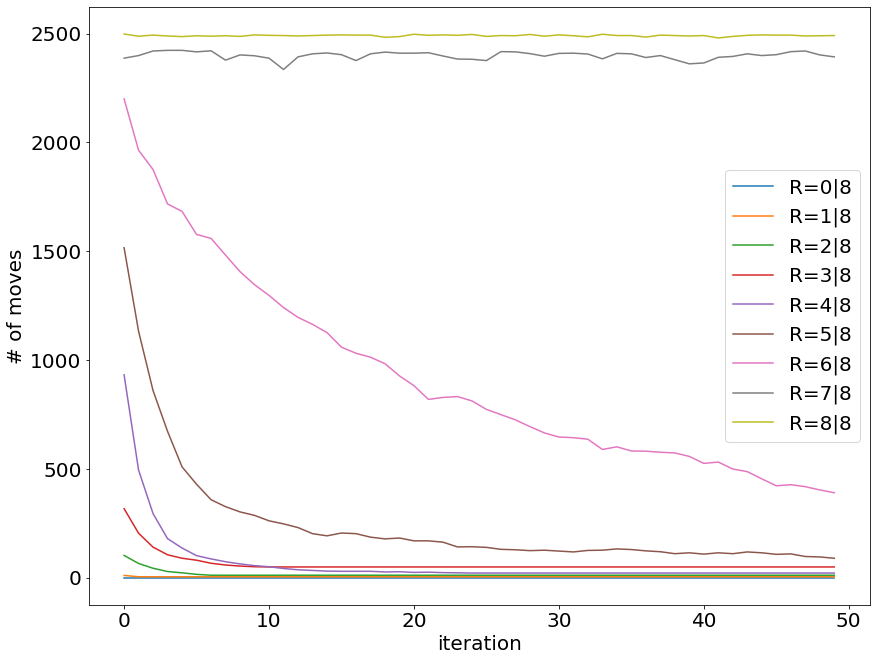

In [25]:
fig, ax = plt.subplots(figsize=(14,11))
# fig.figure(figsize=(14,11))
for i, r in enumerate(R):
    ax.plot(global_moved[i], label=f'R={int(r*8)}|8')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('# of moves', fontsize=20)
    ax.legend(fontsize=20)
# plt.plot(global_moved[0], label='r')

In [ ]:
fig, ax = plt.subplots(figsize=(14,11))
# fig.figure(figsize=(14,11))
for i, r in enumerate(R):
    ax.plot(global_moved_3[i], label=f'R={int(r*8)}|8')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('# of moves', fontsize=20)
    ax.legend(fontsize=20)
# plt.plot(global_moved[0], label='r')

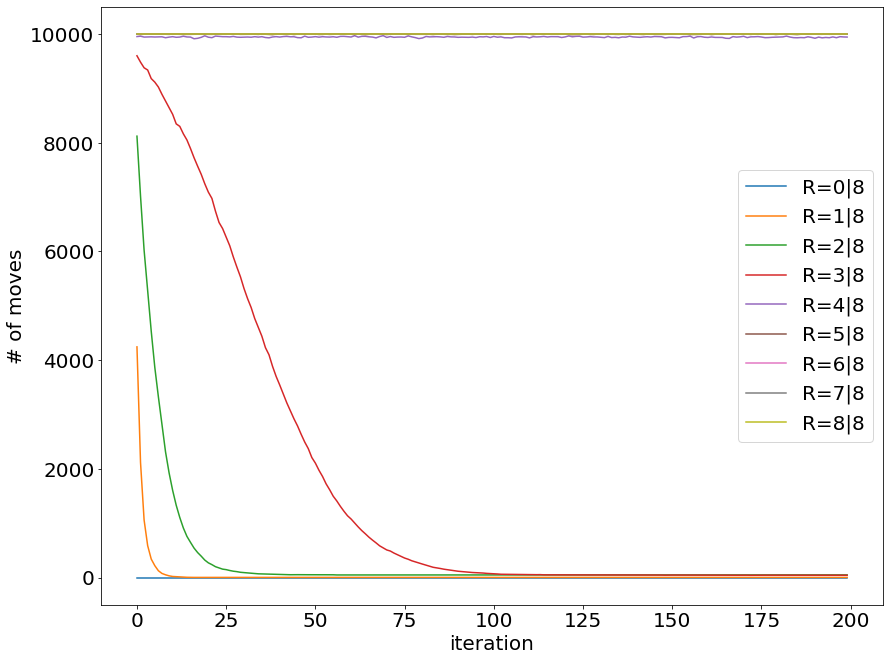

In [44]:
fig, ax = plt.subplots(figsize=(14,11))
for i, r in enumerate(R):
    ax.plot(global_moved_10[i], label=f'R={int(r*8)}|8')
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('# of moves', fontsize=20)
    ax.legend(fontsize=20)
# plt.plot(global_moved[0], label='r')

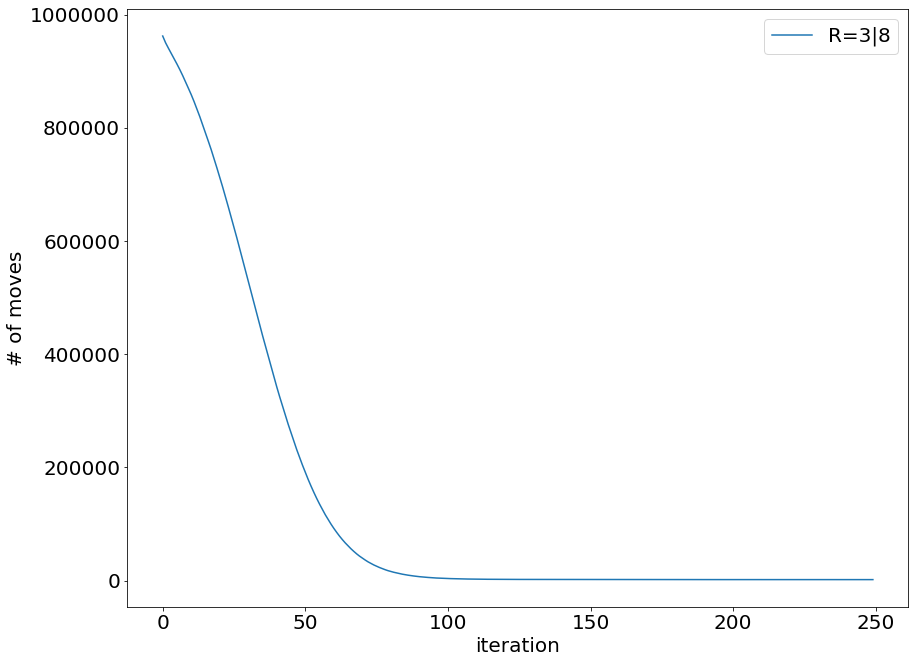

In [53]:
fig, ax = plt.subplots(figsize=(14,11))
ax.plot(_, label=f'R={int(r*8)}|8')
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('# of moves', fontsize=20)
ax.legend(fontsize=20)

## T3.3 Bonus: 3D Schelling model

### Check that everything works correctly
Plot 3D cube and projections on each plane for one class (here I chosen to project class 1), so color defines total number of 'ones' in that plane cell

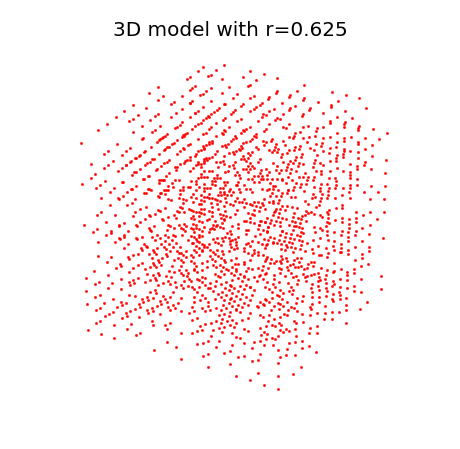

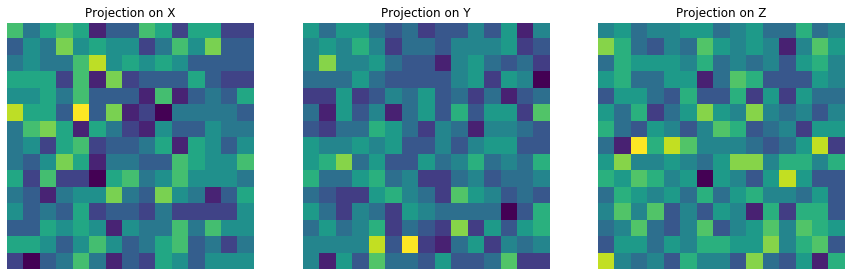

In [18]:
from tqdm.auto import tqdm
from schelling_3d import init_map_3d, prepare_3d_plot, plot_3d, plot_projections
%matplotlib inline
# %matplotlib notebook
R = [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]
N = 15
C = 2 # Number of different neighbourhoods
r = R[5]
game_map = init_map_3d(N,C)
x, y, z, c, proj_x, proj_y, proj_z = prepare_3d_plot(game_map, projections=True)
# Plot 3D cube to check 
plot_3d(x, y, z, c, r, figsize=(8, 8))
# Plot projections
plot_projections(proj_x, proj_y, proj_z)

If we increase N size of cube becomes to big to visialize it properly, some projections are more reliable. ALso notice, that in the beginnig cells are almost evenly distributed.

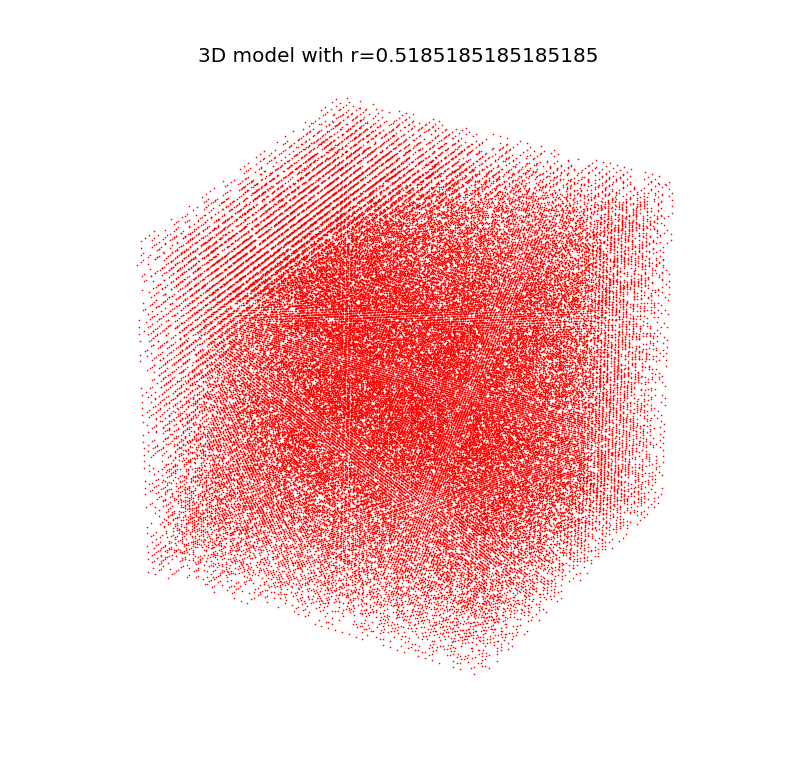

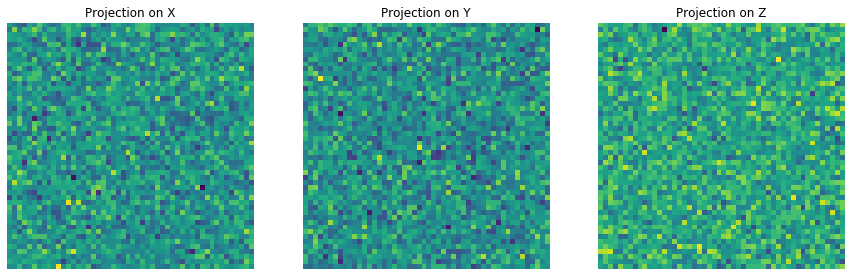

In [36]:
%matplotlib inline
from schelling_3d import plot_3d
R = [0, 1/8, 1/4, 3/8, 1/2, 5/8, 3/4, 7/8, 1]
N = 50
C = 2 # Number of different neighbourhoods
game_map = init_map_3d(N,C)
x, y, z, c, proj_x, proj_y, proj_z = prepare_3d_plot(game_map, projections=True)
plot_3d(x, y, z, c, r, figsize=(14, 14))
plot_projections(proj_x, proj_y, proj_z)

Now let's start the 3D game and see, how distrubutions are changing

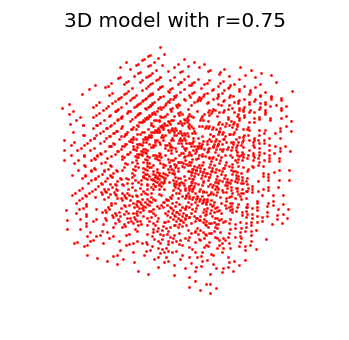

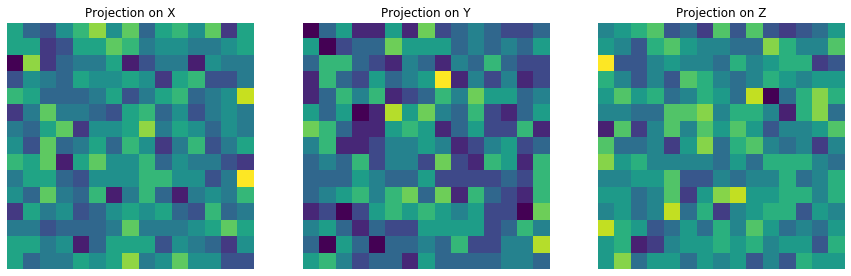

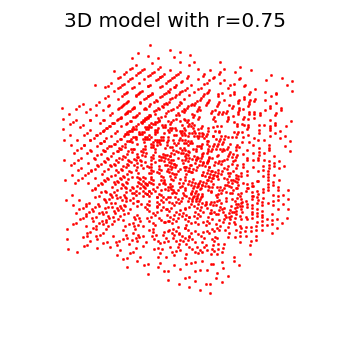

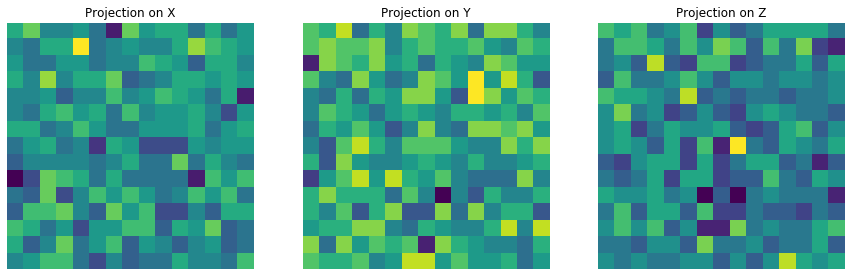

In [24]:
from tqdm.auto import tqdm
from schelling_3d import game_3d
%matplotlib inline

N = 15
C = 2 # Number of different neighbourhoods
game_length = 80
projective=False
r = R[6]
fname=f'schelling_{projective}_{int(r*8)}_{N}_{game_length}'
final_map, moved = game_3d(N, C, r, game_length, name=fname, proj=projective, figsize=(6, 6), fps=8, verbouse=True)

Let's look at the number of moving cells

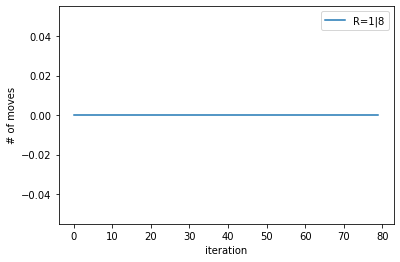

In [186]:
fig, ax = plt.subplots()
# fig.figure(figsize=(14,11))
ax.plot(moved, label=f'R={int(r*27)}|27')
ax.set_xlabel('iteration')
ax.set_ylabel('# of moves')
ax.legend()
plt.savefig(f'imgs/{fname}.png')

### Generate GIFs for different R values
#### First: Find values of R, when something interesting happens.

In [26]:
from tqdm.auto import tqdm
from schelling_3d import game_3d
%matplotlib inline
R_3d = [i / 27 for i in range(27)]
N = 10
C = 2 # Number of different neighbourhoods
game_length = 20
projective=True

global_moved = []
for r in R_3d:
    fname=f'tmp/schelling_{projective}_{int(r*27)}_{N}_{game_length}'
    _, moved = game_3d(N, C, r, game_length, name=fname, proj=projective, figsize=(6, 6), fps=8, verbouse=False)
    global_moved.append(moved)

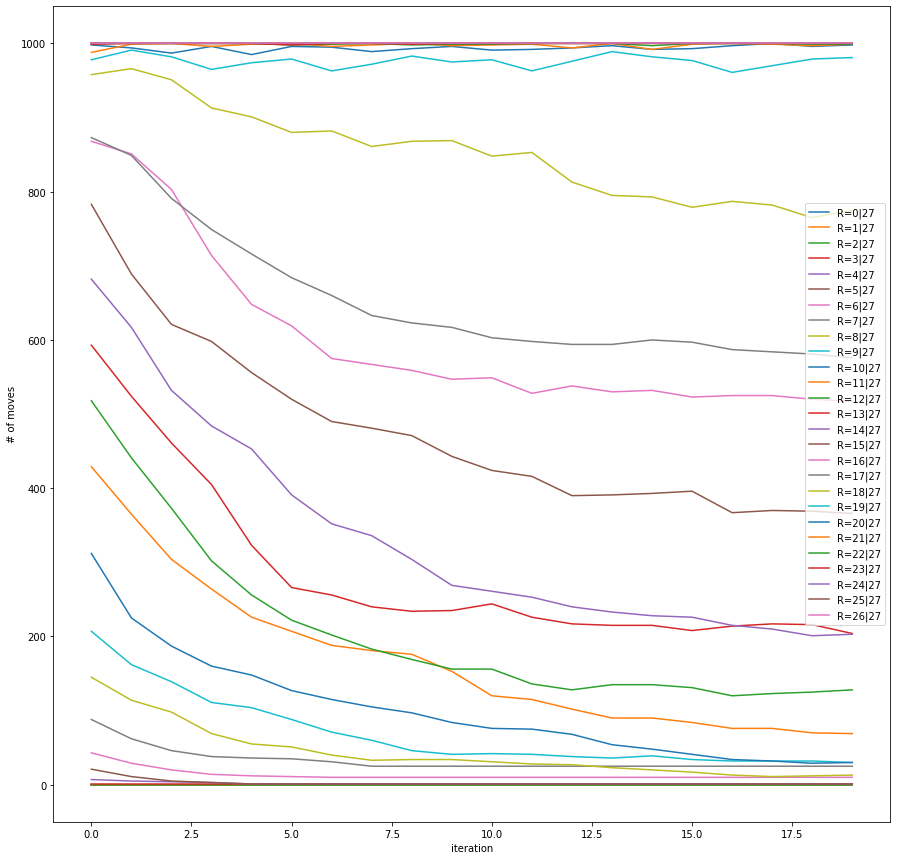

In [204]:
fig, ax = plt.subplots(figsize=(15, 15))
# fig.figure(figsize=(14,11))
for i, r in enumerate(R_3d):
    ax.plot(global_moved[i], label=f'R={int(r*27)}|27')
    ax.set_xlabel('iteration', fontsize=20)
    ax.set_ylabel('# of moves')
    ax.legend()
# plt.plot(global_moved[0], label='r')

#### Let's take $R = 15$ and look how far will it get

In [205]:
from tqdm.auto import tqdm
from schelling_3d import game_3d
%matplotlib inline
N = 100
C = 2 # Number of different neighbourhoods
game_length = 100
projective=True
r = R_3d[15]
fname=f'schelling_{projective}_{int(r*27)}_{N}_{game_length}'
_, moved_15 = game_3d(N, C, r, game_length, name=fname, proj=projective, figsize=(6, 6), fps=8, verbouse=False)

Launch this cell to see gif:
![schelling_3d_15](imgs/schelling_True_15_100_100.gif)


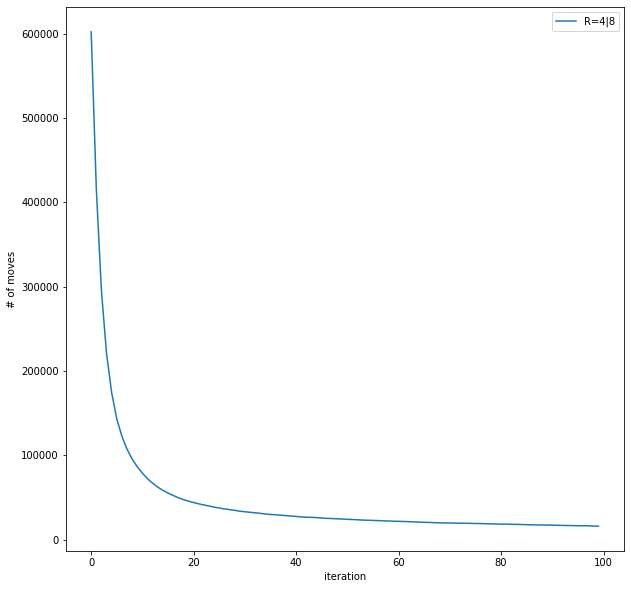

In [206]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(moved_15, label=f'R={int(r*8)}|8')
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('# of moves', fontsize=20)
ax.legend(fontsize=20)
plt.savefig(f'imgs/{fname}.png')

Select R = 14 and wait VERY long.
Set verbouse=True to get initial and final distributions of cells.

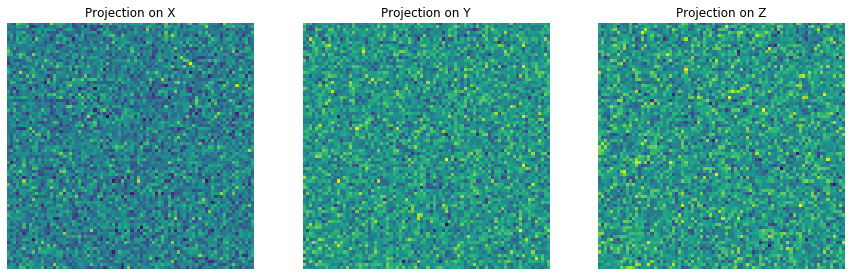

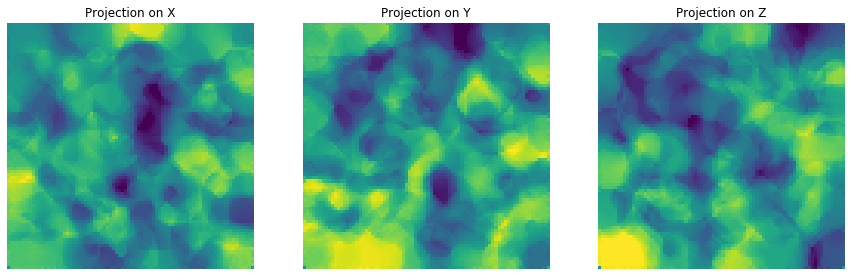

In [27]:
from tqdm.auto import tqdm
from schelling_3d import game_3d
%matplotlib inline
N = 80
C = 2 # Number of different neighbourhoods
game_length = 200
projective=True
r = R_3d[14]
fname=f'schelling_{projective}_{int(r*27)}_{N}_{game_length}'
final_map, moved_14 = game_3d(N, C, r, game_length, name=fname, proj=projective, figsize=(6, 6), fps=8, verbouse=True)

Let's generate GIF for 3D cube

In [38]:
from tqdm.auto import tqdm
from schelling_3d import game_3d
%matplotlib inline
N = 20
C = 2 # Number of different neighbourhoods
game_length = 1000
projective=False
r = R_3d[14]
fname=f'schelling_{projective}_{int(r*27)}_{N}_{game_length}'
final_map, moved_14 = game_3d(N, C, r, game_length, name=fname, proj=projective, figsize=(6, 6), fps=10, verbouse=False)

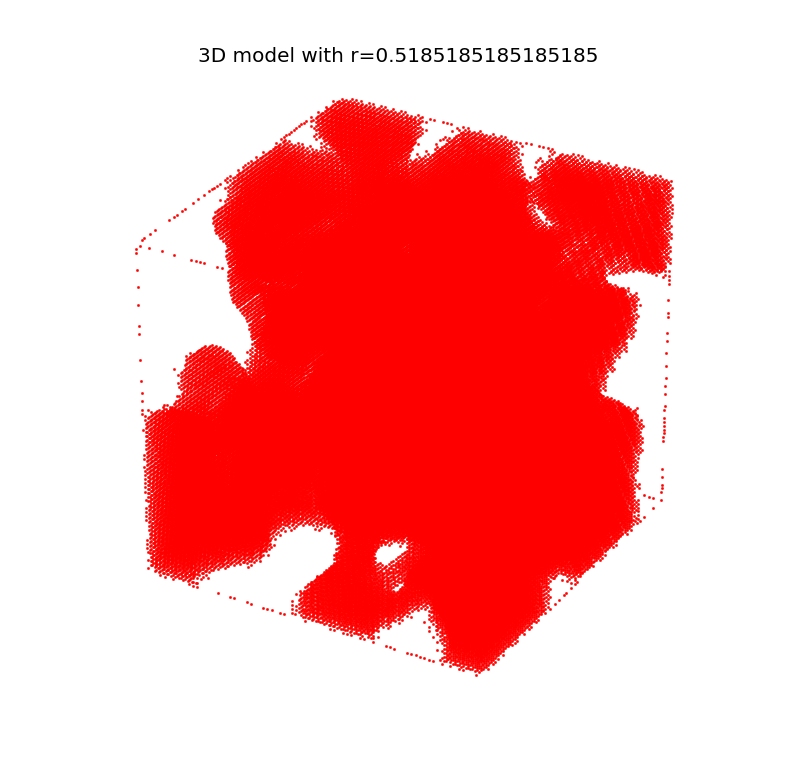

In [33]:
x, y, z, c, proj_x, proj_y, proj_z = prepare_3d_plot(final_map, projections=True)
plot_3d(x, y, z, c, r, figsize=(14, 14))
# plot_projections(proj_x, proj_y, proj_z)

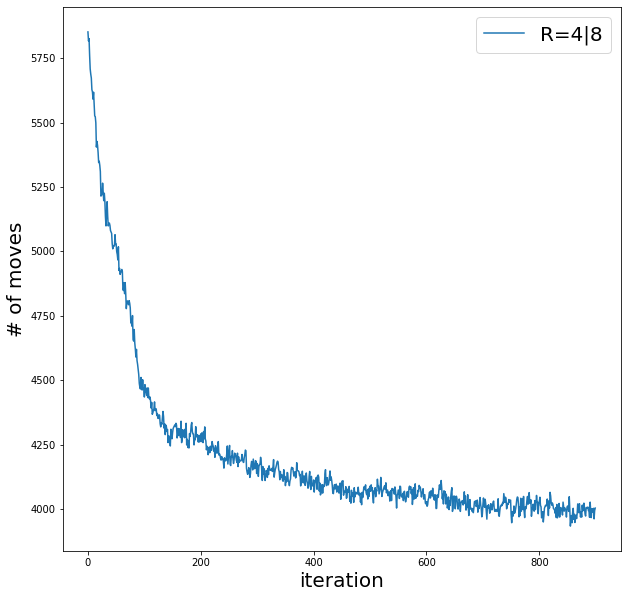

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(moved_14[100:], label=f'R={int(r*8)}|8')
ax.set_xlabel('iteration', fontsize=20)
ax.set_ylabel('# of moves', fontsize=20)
ax.legend(fontsize=20)
plt.savefig(f'imgs/{fname}.png')